In [2]:
import pandas as pd
import networkx as nx
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import tensorly as tl
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, GRU, Reshape, Concatenate, Conv2D, Flatten
from tensorflow.keras.models import Model

In [3]:
df_route = pd.read_excel('route_data/U101.xlsx',index_col=False)

In [112]:
df_route_102 = pd.read_excel('route_data/U102.xlsx',index_col=False)

# DATA PREPARATION FOR CNN HOURLY VARIATION

In [24]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_data(arr):
    # Reshape the array to a 2D matrix with shape (m*n, p)
    reshaped_arr = arr.reshape((-1, arr.shape[-1]))
    # Create a MinMaxScaler object and apply it to the reshaped array
    scaler = MinMaxScaler()
    scaled_arr = scaler.fit_transform(reshaped_arr)
    # Reshape the scaled array back to the original shape
    scaled_arr = scaled_arr.reshape(arr.shape)
    return scaled_arr

def data_prepare_cnn(df_route):
    df_route = df_route[['ETD_DATE','Hour','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(df_route.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)
    land_use = pd.read_csv("Land_Use.csv")
    land_use.fillna(0,inplace=True)
    # merged_data_final = pd.merge(df_route_unique, land_use, left_on='ORIGIN', right_on='STOPS')
    # merged_data_final.drop(columns=['STOPS'],inplace=True)



    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)


    unique_values = pd.unique(df_route_unique[['ORIGIN','DESTINATION']].values.ravel('K'))
    land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0

    pivot_table_for_node_features = np.array(land_use[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL','PARKS', 'PUBLIC_UTILITIES']])
    list_node_features = []
    for i in range(len(tensor_graph_data)):
            list_node_features.append(pivot_table_for_node_features)
    tensor_node_feature = tf.convert_to_tensor(list_node_features)
    tensor_node_feature = np.array(tensor_node_feature)



    ten_target_value = []
    grp_date = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_date:
        adj_matrix_target = np.zeros((51))
        for index, row in df.iterrows():
            adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + int(row['TRAFFIC FLOW'])
        ten_target_value.append(tl.tensor(adj_matrix_target))
    tensor_target_value = tf.convert_to_tensor(ten_target_value)
    tensor_target_value = np.array(tensor_target_value).reshape(len(tensor_graph_data),51,1)

    # tensor_node_feature = scale_data(tensor_node_feature)
    # tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data,tensor_node_feature,tensor_target_value

In [59]:
# df_route = df_route[['ETD_DATE','ORIGIN','DESTINATION']]
# df_route = pd.DataFrame(df_route.value_counts())
# merged_data_final = df_route.reset_index()
# merged_data_final.rename(columns={0:'TRAFFIC FLOW'},inplace=True)

In [133]:
# ten_graph_data = []
# grp_hr = merged_data_final.groupby(['ETD_DATE'])
# for i, df in grp_hr:
#     adj_matrix = np.zeros((51,51))
#     for index, row in df.iterrows():
#         adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
#     ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
# tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
# tensor_graph_data = np.array(tensor_graph_data)
# tensor_graph_data.shape

In [134]:
# ten_target_value = []
# grp_date = merged_data_final.groupby(['ETD_DATE'])
# for i, df in grp_date:
#     adj_matrix_target = np.zeros((51))
#     for index, row in df.iterrows():
#         adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + row['TRAFFIC FLOW']
#     ten_target_value.append(tl.tensor(adj_matrix_target))
# tensor_target_value = tf.convert_to_tensor(ten_target_value)
# tensor_target_value = np.array(tensor_target_value).reshape(183,51,1)
# tensor_target_value.shape

In [6]:
# from sklearn.preprocessing import MinMaxScaler
# import numpy as np

# def scale_data(arr):
#     # Reshape the array to a 2D matrix with shape (m*n, p)
#     reshaped_arr = arr.reshape((-1, arr.shape[-1]))
#     # Create a MinMaxScaler object and apply it to the reshaped array
#     scaler = MinMaxScaler()
#     scaled_arr = scaler.fit_transform(reshaped_arr)
#     # Reshape the scaled array back to the original shape
#     scaled_arr = scaled_arr.reshape(arr.shape)
#     return scaled_arr

In [25]:
tensor_graph_data_scaled,nf,tensor_target_value = data_prepare_cnn(df_route)

C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_8248\3120778653.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0


In [8]:
num_nodes = 51
num_features = 6
num_timesteps = 2688
train_data = tensor_graph_data_scaled[:2151]
train_targets = tensor_target_value[1:2152].astype(np.int64)
test_data = tensor_graph_data_scaled[2151:2687]
test_targets = tensor_target_value[2152:].astype(np.int64)

# CNN without the node features

In [14]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the model architecture
model = tf.keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(51, 51, 1)),
    # layers.MaxPooling2D(pool_size=(2,2)),
    # layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    # layers.MaxPooling2D(pool_size=(2,2)),
    layers.Flatten(),
    # layers.Dense(256, activation='relu'),
    # layers.Dense(128, activation='relu'),
    layers.Dense(51, activation='linear')
])
# Compile the model
model.compile(optimizer='adam', loss='mae')
# Train the model
history = model.fit(train_data, train_targets, epochs=50, batch_size=32, validation_data=(test_data, test_targets))
# Get training and validation loss from the history object
# train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

# # Create a list of epoch numbers
# epochs = range(1, len(train_loss) + 1)

# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# sns.lineplot(train_loss, label="Training Loss")
# sns.lineplot(val_loss, label="Validation Loss")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

Epoch 1/50
68/68 [==============================] - 7s 88ms/step - loss: 4.2590 - val_loss: 3.5212
Epoch 2/50
68/68 [==============================] - 5s 74ms/step - loss: 3.0867 - val_loss: 2.8922
Epoch 3/50
68/68 [==============================] - 5s 76ms/step - loss: 2.5289 - val_loss: 2.5151
Epoch 4/50
68/68 [==============================] - 5s 77ms/step - loss: 2.1790 - val_loss: 2.2631
Epoch 5/50
68/68 [==============================] - 5s 77ms/step - loss: 2.0246 - val_loss: 2.1823
Epoch 6/50
68/68 [==============================] - 5s 71ms/step - loss: 1.9553 - val_loss: 2.1215
Epoch 7/50
68/68 [==============================] - 5s 70ms/step - loss: 1.9093 - val_loss: 2.0772
Epoch 8/50
68/68 [==============================] - 6s 82ms/step - loss: 1.8744 - val_loss: 2.0538
Epoch 9/50
68/68 [==============================] - 5s 75ms/step - loss: 1.8504 - val_loss: 2.0327
Epoch 10/50
68/68 [==============================] - 5s 73ms/step - loss: 1.8256 - val_loss: 2.0060
Epoch 11/

NameError: name 'plt' is not defined

In [16]:
predictions = model.predict(test_data).astype(np.int64)
test_targets = test_targets.reshape(536,51).astype(np.int64)

In [48]:
from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
import math
print("MAPE : " ,mean_absolute_percentage_error(train_targets.reshape(2151,51)[:10],predictions[:10]))
print("MAE : " ,mean_absolute_error(test_targets,predictions))
print("MSE : " ,mean_squared_error(test_targets,predictions))
print("RMSE : ", math.sqrt(mean_squared_error(test_targets,predictions)))

MAPE :  0.23489998849080265
MAE :  1.859452736318408
MSE :  31.955004389815624
RMSE :  5.6528757628145


# DATA PREPARATION FOR LSTM AND ANN

In [79]:
def data_prepare_hr(input_data):
    input_data = input_data[['ETD_DATE','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(input_data.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)

    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)
    return tensor_graph_data

In [80]:
tensor_graph_data = data_prepare_hr(df_route)

C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_8248\3156511175.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in grp_hr:


# LSTM without node features

In [86]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

# Define window size for input/output pairs
window_size = 3

# Create input/output pairs
X = []
y = []
for i in range(len(tensor_graph_data) - window_size):
    X.append(tensor_graph_data[i:i+window_size])
    y.append(tensor_graph_data[i+window_size])


# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Reshape input data to have correct number of dimensions
X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]*X.shape[3])).astype(np.int64)
y = np.reshape(y,(y.shape[0], y.shape[1]*y.shape[2])).astype(np.int64)
# Define LSTM model

model = Sequential()
model.add(LSTM(64, input_shape=(window_size,51*51)))
# model.add(Dropout(0.3))
# model.add(LSTM(64))
# model.add(Dropout(0.3))
model.add(Dense(51*51, activation='sigmoid'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mae')


# Train model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# # Get training and validation loss from the history object
# train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]
# # Create a list of epoch numbers
# epochs = range(1, len(train_loss) + 1)
# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# sns.lineplot(train_loss, label="Training Loss")
# sns.lineplot(val_loss, label="Validation Loss")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


Epoch 1/50
5/5 [==============================] - 4s 150ms/step - loss: 2.0017 - val_loss: 2.1605
Epoch 2/50
5/5 [==============================] - 0s 28ms/step - loss: 1.9722 - val_loss: 2.1243
Epoch 3/50
5/5 [==============================] - 0s 30ms/step - loss: 1.9339 - val_loss: 2.0831
Epoch 4/50
5/5 [==============================] - 0s 32ms/step - loss: 1.8911 - val_loss: 2.0366
Epoch 5/50
5/5 [==============================] - 0s 31ms/step - loss: 1.8455 - val_loss: 1.9903
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 1.8021 - val_loss: 1.9490
Epoch 7/50
5/5 [==============================] - 0s 29ms/step - loss: 1.7631 - val_loss: 1.9122
Epoch 8/50
5/5 [==============================] - 0s 29ms/step - loss: 1.7267 - val_loss: 1.8764
Epoch 9/50
5/5 [==============================] - 0s 36ms/step - loss: 1.6930 - val_loss: 1.8483
Epoch 10/50
5/5 [==============================] - 0s 30ms/step - loss: 1.6666 - val_loss: 1.8232
Epoch 11/50
5/5 [===========

In [103]:
prediction_lstm = model.predict(X).astype(np.int64)
# mapeTensor = tf.keras.losses.mape(prediction,y[:9].astype(np.float64))
# np.mean(mapeTensor.numpy())

from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
import math
print("MAPE : " ,mean_absolute_percentage_error(y,prediction_lstm))
print("MAE : " ,mean_absolute_error(y,prediction_lstm))
print("MSE : " ,mean_squared_error(y,prediction_lstm))
print("RMSE : ", math.sqrt(mean_squared_error(y,prediction_lstm)))

MAPE :  0.05088213934811397
MAE :  1.594649493784442
MSE :  165.012433252168
RMSE :  12.845716533232702


# ANN model without node features

In [124]:
import tensorflow as tf

# Define the model architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(3, 51*51)),
    tf.keras.layers.Flatten(),
    # tf.keras.layers.Dense(128, activation='sigmoid'),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dense(51*51, activation='sigmoid')
])

# Compile the model with appropriate loss function, optimizer and metric
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mae')

# Train model
history = model.fit(X, y, epochs=50, batch_size=32, validation_split=0.2)

# # Get training and validation loss from the history object
# train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

# # Create a list of epoch numbers
# epochs = range(1, len(train_loss) + 1)

# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# sns.lineplot(train_loss, label="Training Loss")
# sns.lineplot(val_loss, label="Validation Loss")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()


Epoch 1/50
5/5 [==============================] - 1s 110ms/step - loss: 1.6467 - val_loss: 1.6870
Epoch 2/50
5/5 [==============================] - 0s 38ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 3/50
5/5 [==============================] - 0s 32ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 4/50
5/5 [==============================] - 0s 37ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 5/50
5/5 [==============================] - 0s 38ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 6/50
5/5 [==============================] - 0s 31ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 7/50
5/5 [==============================] - 0s 30ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 8/50
5/5 [==============================] - 0s 36ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 9/50
5/5 [==============================] - 0s 26ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 10/50
5/5 [==============================] - 0s 28ms/step - loss: 1.5235 - val_loss: 1.6869
Epoch 11/50
5/5 [===========

In [125]:
prediction_ann = model.predict(X).astype(np.int64)

from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
import math
print("MAPE : " ,mean_absolute_percentage_error(y,prediction_ann))
print("MAE : " ,mean_absolute_error(y,prediction_ann))
print("MSE : " ,mean_squared_error(y,prediction_ann))
print("RMSE : ", math.sqrt(mean_squared_error(y,prediction_ann)))

MAPE :  45634321483714.91
MAE :  1.556157887991798
MSE :  162.04808834209067
RMSE :  12.729811009676878


# TESTING WITH OTHER ROUTES

In [113]:
testing = data_prepare_hr(df_route_102)

C:\Users\HIMANGSHUB\AppData\Local\Temp\ipykernel_8248\3156511175.py:9: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for i, df in grp_hr:


In [129]:
window_size = 3

# Create input/output pairs
X_t = []
y_t = []
for i in range(len(testing) - window_size):
    X_t.append(testing[i:i+window_size])
    y_t.append(testing[i+window_size])


# Convert to numpy arrays
X_t = np.array(X_t)
y_t = np.array(y_t)

# Reshape input data to have correct number of dimensions
X_t = np.reshape(X_t, (X_t.shape[0], X_t.shape[1], X_t.shape[2]*X_t.shape[3])).astype(np.int64)
y_t = np.reshape(y_t,(y_t.shape[0], y_t.shape[1]*y_t.shape[2])).astype(np.int64)

In [132]:
prediction_ann_test = model.predict(X_t).astype(np.int64)

from sklearn.metrics import mean_absolute_percentage_error , mean_absolute_error , mean_squared_error
import math
print("MAPE : " ,mean_absolute_percentage_error(y_t[:5],prediction_ann_test[:5]))
print("MAE : " ,mean_absolute_error(y_t,prediction_ann_test))
print("MSE : " ,mean_squared_error(y_t,prediction_ann_test))
print("RMSE : ", math.sqrt(mean_squared_error(y_t,prediction_ann_test)))

MAPE :  228902680022445.06
MAE :  1.5801038062283739
MSE :  155.5891131616045
RMSE :  12.473536513820148


# FULL NETWORK PREDICTION

In [3]:
df0 = pd.read_excel("route_data/U101.xlsx",index_col=False)
df1 = pd.read_excel('route_data/U102.xlsx',index_col=False)
df2 = pd.read_excel('route_data/U105.xlsx',index_col=False)
df3 = pd.read_excel('route_data/U106.xlsx',index_col=False)
df4 = pd.read_excel('route_data/U107.xlsx',index_col=False)
df5 = pd.read_excel('route_data/U108.xlsx',index_col=False)

In [4]:
full_network = pd.concat([df0,df1,df2,df3,df4,df5],axis=0,ignore_index=True)

In [87]:
def data_prepare(input_data):
    input_data = input_data[['ETD_DATE','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(input_data.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)

    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)

    # tensor_node_feature = scale_data(tensor_node_feature)
    # tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data

In [6]:
def data_prepare_hr(input_data):
    input_data = input_data[['ETD_DATE','Hour','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(input_data.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)

    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)

    # tensor_node_feature = scale_data(tensor_node_feature)
    # tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data

In [7]:
input_tensor = data_prepare_hr(full_network)

Epoch 1/100
60/60 [==============================] - 13s 80ms/step - loss: 0.5349 - val_loss: 0.4825
Epoch 2/100
60/60 [==============================] - 3s 57ms/step - loss: 0.3910 - val_loss: 0.3529
Epoch 3/100
60/60 [==============================] - 4s 62ms/step - loss: 0.3383 - val_loss: 0.3172
Epoch 4/100
60/60 [==============================] - 3s 56ms/step - loss: 0.3241 - val_loss: 0.3121
Epoch 5/100
60/60 [==============================] - 3s 54ms/step - loss: 0.3178 - val_loss: 0.3082
Epoch 6/100
60/60 [==============================] - 3s 58ms/step - loss: 0.3144 - val_loss: 0.3046
Epoch 7/100
60/60 [==============================] - 3s 50ms/step - loss: 0.3096 - val_loss: 0.3042
Epoch 8/100
60/60 [==============================] - 4s 59ms/step - loss: 0.3078 - val_loss: 0.3000
Epoch 9/100
60/60 [==============================] - 3s 53ms/step - loss: 0.3050 - val_loss: 0.3028
Epoch 10/100
60/60 [==============================] - 3s 50ms/step - loss: 0.3059 - val_loss: 0.303

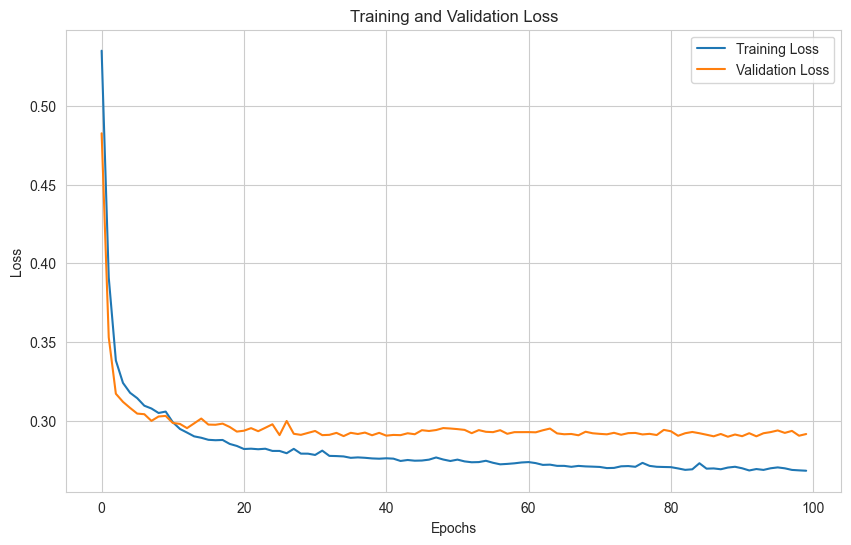

In [12]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

window_size = 7
X_full = []
y_full = []
for i in range(len(input_tensor) - window_size):
    X_full.append(input_tensor[i:i+window_size])
    y_full.append(input_tensor[i+window_size])


# Convert to numpy arrays
X_full = np.array(X_full)
y_full = np.array(y_full)

# Reshape input data to have correct number of dimensions
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], X_full.shape[2]*X_full.shape[3]))
y_full = np.reshape(y_full,(y_full.shape[0], y_full.shape[1]*y_full.shape[2]))

model = Sequential()
model.add(LSTM(64, input_shape=(window_size,51*51), return_sequences=True ))
model.add(Dropout(0.1))
model.add(LSTM(64))
model.add(Dropout(0.1))
model.add(Dense(51*51, activation='linear'))
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='mae')

# Train model
history = model.fit(X_full, y_full, epochs=100, batch_size=32, validation_split=0.2)

# Get training and validation loss from the history object
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]
# Create a list of epoch numbers
epochs = range(1, len(train_loss) + 1)
# Plot training and validation loss
plt.figure(figsize=(10, 6))
sns.lineplot(train_loss, label="Training Loss")
sns.lineplot(val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [14]:
# prediction = model.predict(X_full[:150]).astype(np.int64)
# mapeTensor = tf.keras.losses.mean_absolute_error(y_full[:150],prediction)
# np.mean(mapeTensor.numpy())

In [91]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def scale_data(arr):
    # Reshape the array to a 2D matrix with shape (m*n, p)
    reshaped_arr = arr.reshape((-1, arr.shape[-1]))
    # Create a MinMaxScaler object and apply it to the reshaped array
    scaler = MinMaxScaler()
    scaled_arr = scaler.fit_transform(reshaped_arr)
    # Reshape the scaled array back to the original shape
    scaled_arr = scaled_arr.reshape(arr.shape)
    return scaled_arr


In [92]:
def data_prepare_temp(df_route):
    df_route = df_route[['ETD_DATE','Hour','ORIGIN','DESTINATION']]
    df_route_unique = pd.DataFrame(df_route.value_counts())
    df_route_unique = df_route_unique.reset_index()
    df_route_unique.rename(columns={0:'TRAFFIC FLOW'},inplace=True)
    land_use = pd.read_csv("Land_Use.csv")
    land_use.fillna(0,inplace=True)
    # merged_data_final = pd.merge(df_route_unique, land_use, left_on='ORIGIN', right_on='STOPS')
    # merged_data_final.drop(columns=['STOPS'],inplace=True)



    ten_graph_data = []
    grp_hr = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_hr:
        adj_matrix = np.zeros((51,51))
        for index, row in df.iterrows():
            adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] = adj_matrix[int(row['ORIGIN'])][int(row['DESTINATION'])] + int(row['TRAFFIC FLOW'])
        ten_graph_data.append(tl.tensor(adj_matrix).reshape(51,51))
    tensor_graph_data = tf.convert_to_tensor(ten_graph_data)
    tensor_graph_data = np.array(tensor_graph_data)


    # unique_values = pd.unique(merged_data_final[['ORIGIN','DESTINATION']].values.ravel('K'))
    # land_use[land_use['STOPS'].isin(unique_values)==False][['COMMERCIAL','PUBLIC_and_SEMI_PUBLIC','INDUSTRIAL','RESIDENTIAL','PARKS','PUBLIC_UTILITIES']] = 0

    pivot_table_for_node_features = np.array(land_use[['COMMERCIAL', 'PUBLIC_and_SEMI_PUBLIC', 'INDUSTRIAL', 'RESIDENTIAL','PARKS', 'PUBLIC_UTILITIES']])
    list_node_features = []
    for i in range(len(tensor_graph_data)):
            list_node_features.append(pivot_table_for_node_features)
    tensor_node_feature = tf.convert_to_tensor(list_node_features)
    tensor_node_feature = np.array(tensor_node_feature)



    ten_target_value = []
    grp_date = df_route_unique.groupby(['ETD_DATE','Hour'])
    for i, df in grp_date:
        adj_matrix_target = np.zeros((51))
        for index, row in df.iterrows():
            adj_matrix_target[int(row['ORIGIN'])] = adj_matrix_target[int(row['ORIGIN'])] + row['TRAFFIC FLOW']
        ten_target_value.append(tl.tensor(adj_matrix_target))
    tensor_target_value = tf.convert_to_tensor(ten_target_value)
    tensor_target_value = np.array(tensor_target_value).reshape(len(tensor_graph_data),51,1)

    tensor_node_feature = scale_data(tensor_node_feature)
    tensor_graph_data = scale_data(tensor_graph_data)


    return tensor_graph_data,tensor_node_feature,tensor_target_value

In [138]:
# tensor_graph_data_t,tensor_node_feature_t,tensor_target_value_t = data_prepare_temp(full_network)

In [137]:
# tensor_graph_data_t.shape,tensor_node_feature_t.shape,tensor_target_value_t.shape

In [95]:
# num_nodes = 51
# num_features = 6
# num_timesteps = 2714
# train_data = {"adj_matrix": tensor_graph_data_t[:2172], "node_features": tensor_node_feature_t[:2172]}
# train_targets = tensor_target_value_t[1:2173].astype(np.int64)
# test_data = {"adj_matrix": tensor_graph_data_t[2172:2713], "node_features": tensor_node_feature_t[2172:2713]}
# test_targets = tensor_target_value_t[2173:].astype(np.int64)

In [135]:
# import tensorflow as tf
# from spektral.layers import GCNConv
# from sklearn.ensemble import BaggingRegressor
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_style("whitegrid")


# class GCN(tf.keras.Model):
#     def __init__(self, num_features, num_timesteps,num_nodes):
#         super(GCN, self).__init__()

#         self.conv1 = GCNConv(256 ,activation="relu")
#         self.conv2 = GCNConv(128, activation="relu")
#         self.flatten = tf.keras.layers.Flatten()
#         self.dense1 = tf.keras.layers.Dense(256, activation="relu")
#         self.dense2 = tf.keras.layers.Dense(128, activation="relu")
#         self.dense3 = tf.keras.layers.Dense(num_nodes)

#         self.adj_shape = (num_timesteps, None, None)
#         self.features_shape = (num_timesteps, None, num_features)

#     def call(self, inputs):
#         x, a = inputs["node_features"], inputs["adj_matrix"]
#         a = tf.transpose(a, perm=[0, 2, 1])
#         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
#         x = self.conv1([x, a])
#         x = self.conv2([x, a])
#         x = self.flatten(x)
#         x = self.dense1(x)
#         x = self.dense2(x)
#         x = self.dense3(x)

#         return x



# # class GCN(tf.keras.Model):
# #     def __init__(self, num_features, num_timesteps, num_nodes, dropout_rate=0.2):
# #         super(GCN, self).__init__()

# #         self.conv1 = GCNConv(256, activation="relu")
# #         self.conv2 = GCNConv(128, activation="relu")
# #         self.conv3 = GCNConv(64, activation="relu")
# #         self.flatten = tf.keras.layers.Flatten()
# #         self.dense1 = tf.keras.layers.Dense(32, activation="relu")
# #         self.dense2 = tf.keras.layers.Dense(num_nodes*1, activation="linear")

# #         self.dropout = tf.keras.layers.Dropout(dropout_rate)
# #         self.adj_shape = (num_timesteps, None, None)
# #         self.features_shape = (num_timesteps, None, num_features)

# #     def call(self, inputs):
# #         x, a = inputs["node_features"], inputs["adj_matrix"]
# #         a = tf.transpose(a, perm=[0, 2, 1])
# #         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
# #         x = self.conv1([x, a])
# #         x = self.dropout(x)
# #         x = self.conv2([x, a])
# #         x = self.dropout(x)
# #         x = self.conv3([x, a])
# #         x = self.dropout(x)
# #         x = self.flatten(x)
# #         x = self.dense1(x)
# #         x = self.dropout(x)
# #         x = self.dense2(x)

# #         return x



# # import tensorflow as tf
# # from spektral.layers import GCNConv
# # from sklearn.ensemble import BaggingRegressor

# # class GCN(tf.keras.Model):
# #     def __init__(self, num_features, num_timesteps, num_nodes, dropout_rate=0.1):
# #         super(GCN, self).__init__()

# #         self.conv1 = GCNConv(256, activation="relu")
# #         self.conv2 = GCNConv(128, activation="relu")
# #         self.conv3 = GCNConv(64, activation="relu")
# #         self.flatten = tf.keras.layers.Flatten()
# #         self.dense1 = tf.keras.layers.Dense(64, activation="relu")
# #         self.dense2 = tf.keras.layers.Dense(32, activation="relu")
# #         self.dense3 = tf.keras.layers.Dense(num_nodes*1)

# #         self.dropout = tf.keras.layers.Dropout(dropout_rate)
# #         self.adj_shape = (num_timesteps, None, None)
# #         self.features_shape = (num_timesteps, None, num_features)

# #     def call(self, inputs):
# #         x, a = inputs["node_features"], inputs["adj_matrix"]
# #         a = tf.transpose(a, perm=[0, 2, 1])
# #         a = tf.linalg.matmul(a, tf.transpose(a, perm=[0, 2, 1]))
# #         x = self.conv1([x, a])
# #         x = self.dropout(x)
# #         x = self.conv2([x, a])
# #         x = self.dropout(x)
# #         x = self.conv3([x, a])
# #         x = self.dropout(x)
# #         x = self.flatten(x)
# #         x = self.dense1(x)
# #         x = self.dropout(x)
# #         x = self.dense2(x)
# #         x = self.dropout(x)
# #         x = self.dense3(x)
# #         return x

# model = GCN(num_features=num_features, num_timesteps=num_timesteps,num_nodes=num_nodes)
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss="mae" )
# history = model.fit(train_data, train_targets, epochs=100, batch_size=32, validation_data=(test_data, test_targets))

# # Get training and validation loss from the history object
# train_loss = history.history["loss"]
# val_loss = history.history["val_loss"]

# # Create a list of epoch numbers
# epochs = range(1, len(train_loss) + 1)

# # Plot training and validation loss
# plt.figure(figsize=(10, 6))
# sns.lineplot(train_loss, label="Training Loss")
# sns.lineplot(val_loss, label="Validation Loss")
# plt.title("Training and Validation Loss")
# plt.xlabel("Epochs")
# plt.ylabel("Loss")
# plt.legend()
# plt.show()

In [102]:
# def mape(y_test, pred):
#     y_test, pred = np.array(y_test), np.array(pred)
#     mape = np.mean(np.abs((y_test - pred) / y_test))*100
#     return mape

In [104]:
# predictions = model.predict(train_data)
# train_targets = train_targets.reshape(2172,51)

In [136]:
# mapeTensor = mape(predictions,train_targets)
# mapeTensor